# Time Series Forecasting of Temperature in Jena, Germany

#### This notebook provides a comprehensive implementation of a LSTM Recurrent Neural Network to forecast the temperature in Jena using a Time Series Dataset (A univariate Time Series Forecasting solution).

#### Problem Representation and Data formulation
1. Dataset overview: The dataset used is the "Jena Climate 2009-2016" dataset, which has 15 columns with features such as temperature,pressure,humidity,windspeed, etc. It contains 420224 data points, recorded every 10 minutes over the span of 2009-2016 
2. Feature extraction: For this task, I focus only on the temperature feature ('T (degC')), which is the aim of prediction using a TimeSeries forecasting approach.
3. Time Series data preparation: Input, output pairs are generated using the 'T (degC)' feature where each input consists of a sequence of past temperature readings and the corresponding output is the temperature at the next step. 
4. Train-Test split: I splitted the Time Series data such that 70% of it were used for training while the rest were used for testing.
5. Modelling: I used the LSTM neural network as the model due to its ability to capture long-term dependencies in sequential data. 

#### Main steps of the LSTM Recurrent Neural Network
1. Takes in a sequence of past temperature values (Time steps). 
2. For a given sequence, takes the first temperature value, processes it along with the initial hidden state and cell state. Moves to the next time step, processes it using updated hidden state and cell state and so on until all timesteps are reached.
3. After that, the LSTM produces an ouput which is passed to the next layer which generates a prediction.
4. Then, by the process of backward propagation through time, the parameters are updated until the loss is minimum. 

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
from keras.losses import MeanSquaredError

In [32]:
def get_pred_df(path, feature):
    """Return the feature to be predicted

    Args:
        path (string): Path of the csv file
        feature (string): Feature to be predicted

    Returns:
        pandas.DataFrame: Dataframe of the feature to be predicted
    """
    df = pd.read_csv(path)
    pred_df = df[feature] #the feature to be predicted
    return pred_df

In [33]:
def create_dataset(pred_df, time_steps):
    """Create the dataset in a format that is suitable for TimeSeries forecasting

    Args:
        pred_df (pandas DataFrame): Dataframe (Single column) of the feature to be predicted
        time_steps (int): How many previous steps to use as input features for the predicting the next value in the series

    Returns:
        (numpy array, numpy array): x (input datapoints) and y(labels) in the format that is suitable for TimeSeries forecasting
    """
    pred_df_np = pred_df.to_numpy() #Convert to numpy array
    x,y = [], []

    for i in range(len(pred_df_np)-time_steps):
        row = [[a] for a in pred_df_np[i:i+time_steps]] #Formats the row into [samples, time steps, features]
        x.append(row)
        label = pred_df_np[i+time_steps]
        y.append(label)

    return np.array(x), np.array(y)

In [34]:
def train_test_split(x, y, train_ratio=0.7):
    """Split the dataset into train and test

    Args:
        x (numpy array): A 3D array that represents input datapoints
        y (numpy array): A 1D array that represents labels
        train_ratio (float): Ratio of training data. Defaults to 0.7.

    Returns:
        (numpy array, numpy array, numpy array, numpy array): Train and test datasets
    """
    train_size = int(len(x)*train_ratio)
    x_train, y_train = x[:train_size], y[:train_size]
    x_test, y_test = x[train_size:], y[train_size:]
    return x_train, y_train, x_test, y_test

In [35]:
def build_train_LSTM(trainx,trainy, timesteps, num_features, epochs, batch_size):
    """Build and train the LSTM model

    Args:
        trainx (numpy array): Training set 
        trainy (numpy array): Training labels
        timesteps (int): How many previous steps to use as input features for the predicting the next value in the series
        num_features (int): Number of features to predict
        epochs (int): Number of epochs (The number of complete passes through the entire dataset)
        batch_size (int):  The number of training samples to work through before the model’s internal parameters are updated.
    """
    #Initializing the Sequential model
    model = tf.keras.Sequential()

    # Add a LSTM layer with 64 units (neurons)
    # input_shape=(timesteps, num_features): This defines the shape of the input to the LSTM layer. Where,
    # timesteps is the number of timesteps in each sequence, num_features is the number of features in each sequence (temperature in this case).
    model.add(LSTM(units=64, input_shape=(timesteps, num_features)))

    # Add a Dense layer with 8 units and ReLU activation function. This layer is a fully connected layer that will follow the LSTM layer.
    # ReLU is used to introduce non-linearity into the model.
    model.add(Dense(units=8, activation='relu'))

    # Add a Dense layer with 1 unit and linear activation function. This layer is the output layer of the model.
    model.add(Dense(units=1, activation='linear'))

    # Print the summary of the model
    model.summary() 

    model.compile(loss=MeanSquaredError(), optimizer='adam', metrics=[MeanSquaredError()])
    model.fit(trainx, trainy, epochs=epochs, batch_size=batch_size, verbose=2)

    return model

In [36]:
def plot_train_preds(model, trainx, trainy):
    """Plotting training set predictions Vs Actual values

    Args:
        model (keras.Sequential): Trained model (LSTM RNN)
        trainx (numpy array): Training set inputs
        trainy (numpy array): Training set labels
    """
    train_preds = model.predict(trainx).flatten() #convert into a 1D array for the ease of plotting
    train_results = pd.DataFrame(data={'Train Predictions':train_preds, 'Actuals':trainy}) #a dataframe containing the predictions and actual values

    plt.figure(figsize=(10,8))
    plt.plot(train_results['Train Predictions'][0:1000])
    plt.plot(train_results['Actuals'][0:1000])
    plt.legend(['Train Predictions', 'Actuals'])
    plt.show()

In [37]:
def plot_test_preds(model, testx, testy):
    """Plotting training set predictions Vs Actual values

    Args:
        model (keras.Sequential): Trained model (LSTM RNN)
        testx (numpy array): Testing set inputs
        testy (numpy array): Testing set labels
    """
    test_preds = model.predict(testx).flatten() #convert into a 1D array for the ease of plotting
    test_results = pd.DataFrame(data={'Test Predictions':test_preds, 'Actuals':testy}) #a dataframe containing the predictions and actual values

    plt.figure(figsize=(10,8))
    plt.plot(test_results['Test Predictions'][0:1000])
    plt.plot(test_results['Actuals'][0:1000])
    plt.legend(['Test Predictions', 'Actuals'])
    plt.show()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4600/4600 - 31s - loss: 1.7044 - mean_squared_error: 1.7043 - 31s/epoch - 7ms/step
Epoch 2/100
4600/4600 - 25s - loss: 0.0480 - mean_squared_error: 0.0480 - 25s/epoch - 5ms/step
Epoch 3/100
4600/4600 - 22s - loss: 0.0465 - mean_squared_error: 0.0465 - 22s/epoch - 5ms/st

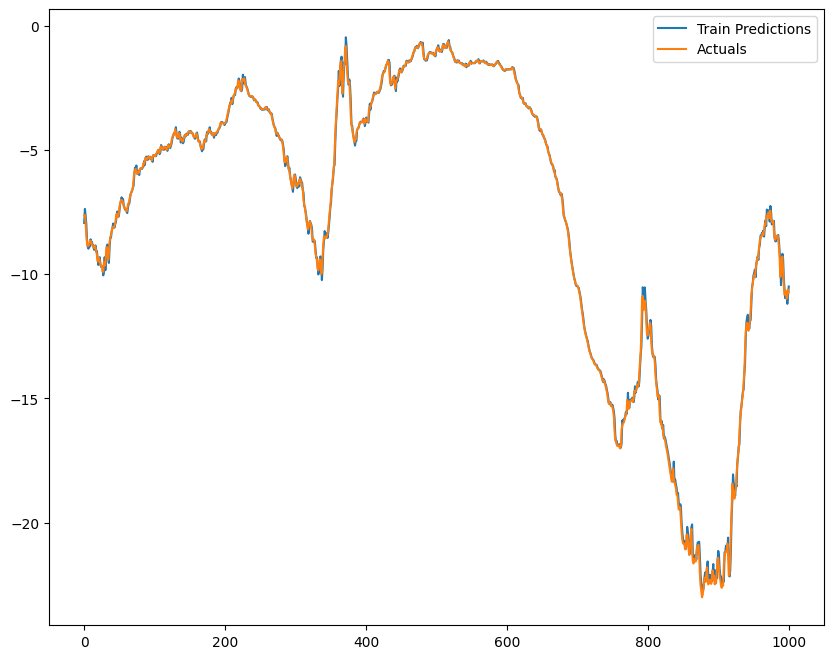

3943/3943 [==============================] - 16s 4ms/step


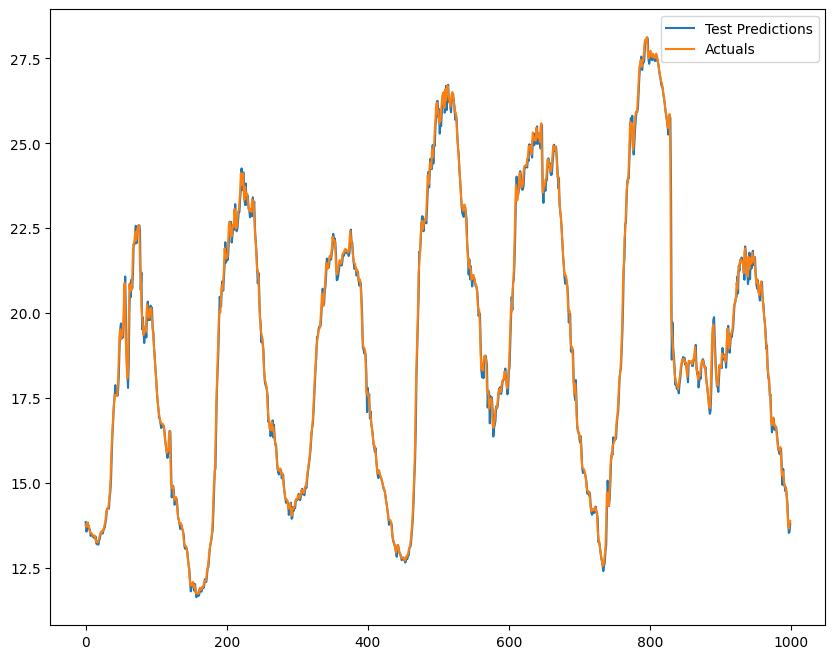

In [38]:
def main():
    path = 'jena_climate_2009_2016.csv'
    feature = 'T (degC)'
    pred_df = get_pred_df(path, feature)
    #Each row in the dataset has a time interval of 10 minutes. By setting time_steps to 6,
    #the input data for the model will have an hour of past data. 
    time_steps = 6 
    x,y = create_dataset(pred_df, time_steps)

    trainx, trainy, testx, testy = train_test_split(x, y)
    
    epochs = 100
    batch_size = 64
    model = build_train_LSTM(trainx, trainy, time_steps, 1, epochs, batch_size)

    plot_train_preds(model, trainx, trainy)
    plot_test_preds(model, testx, testy)

if __name__ == '__main__':
    main()